In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm

%matplotlib inline
from scipy.optimize import curve_fit, minimize
import strax
import straxbra

In [5]:
ctx = straxbra.XebraContext()
run = '00226'
# peaks_data_xebra = ctx.get_array(run, 'peaks')
# ncomp = ctx.get_array(run, 'n_competing')
event_basics = ctx.get_array(run, 'event_basics')
# records_data = ctx.get_array(run, 'records')
# raw_records_data = ctx.get_array(run, 'raw_records')
# ctx.data_info('peaks')
# ctx.data_info('n_competing')
# ctx.data_info('event_basics')

/software/straxbra/straxbra/plugins.py:372: RuntimeWarning: invalid value encountered in true_divide
  return LRF_PMTs_array / (np.sum(LRF_PMTs_array))
/software/straxbra/straxbra/plugins.py:377: RuntimeWarning: divide by zero encountered in true_divide
  reconstruct = lambda x: np.sum(((self.LRF_PMTs(x[0], x[1]) - HFs_input)**2) / (self.LRF_PMTs(x[0], x[1])))
/software/straxbra/straxbra/plugins.py:377: RuntimeWarning: invalid value encountered in true_divide
  reconstruct = lambda x: np.sum(((self.LRF_PMTs(x[0], x[1]) - HFs_input)**2) / (self.LRF_PMTs(x[0], x[1])))


,Field name,Data type,Comment
0,channel,int16,Channel/PMT number
1,dt,int16,Time resolution in ns
2,time,int64,Start time of the interval (ns since unix epoch)
3,length,int32,Length of the interval in samples
4,area,float32,Integral across channels in photoelectrons
5,area_per_channel,"('<f4', (8,))",Integral per channel in PE
6,n_hits,int32,Number of hits from which peak was constructed...
7,data,"('<f4', (200,))",Waveform data in PE/sample (not PE/ns!)
8,width,"('<f4', (11,))",Peak widths in ns: range of central area fraction
9,area_decile_from_midpoint,"('<f4', (11,))",Peak widths in ns: area from midpoint


In [ ]:
ctx.data_info('n_competing')

In [ ]:
ctx.data_info('event_basics')

In [ ]:
ctx.data_info('records')

In [6]:
S1_area = event_basics['s1_area']
S2_area = event_basics['s2_area']

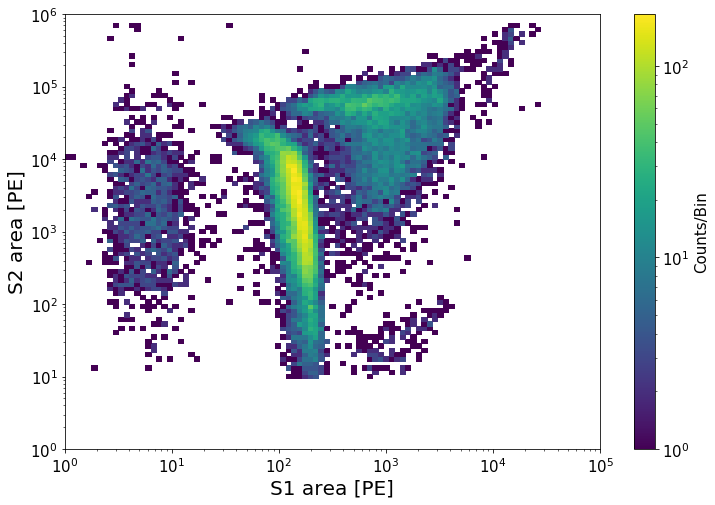

In [9]:
fig, ax = plt.subplots(figsize=(12,8))

bins_x = np.logspace(0,5,100)
bins_y = np.logspace(0,6,100)
histo_max= 2*10**3

counts, _, _ = np.histogram2d(S1_area, S2_area, bins=(bins_x, bins_y))

im = ax.pcolormesh(bins_x, bins_y, counts.T, cmap='viridis', norm=mcolors.LogNorm())
ax.set_xlabel('S1 area [PE]', fontsize = 20)
ax.set_ylabel('S2 area [PE]', fontsize = 20)

#ax.set_title(' xxx', fontsize= 15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.set_xscale('log')
ax.set_yscale('log')
cbar = plt.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label ='Counts/Bin', fontsize=15)

In [ ]:
plt.figure(figsize=(18,13))
plt.hist(ncomp['n_competing'], bins=np.arange(20))
plt.show()

[53.63  0.   20.54 ... 26.78  0.   20.07]


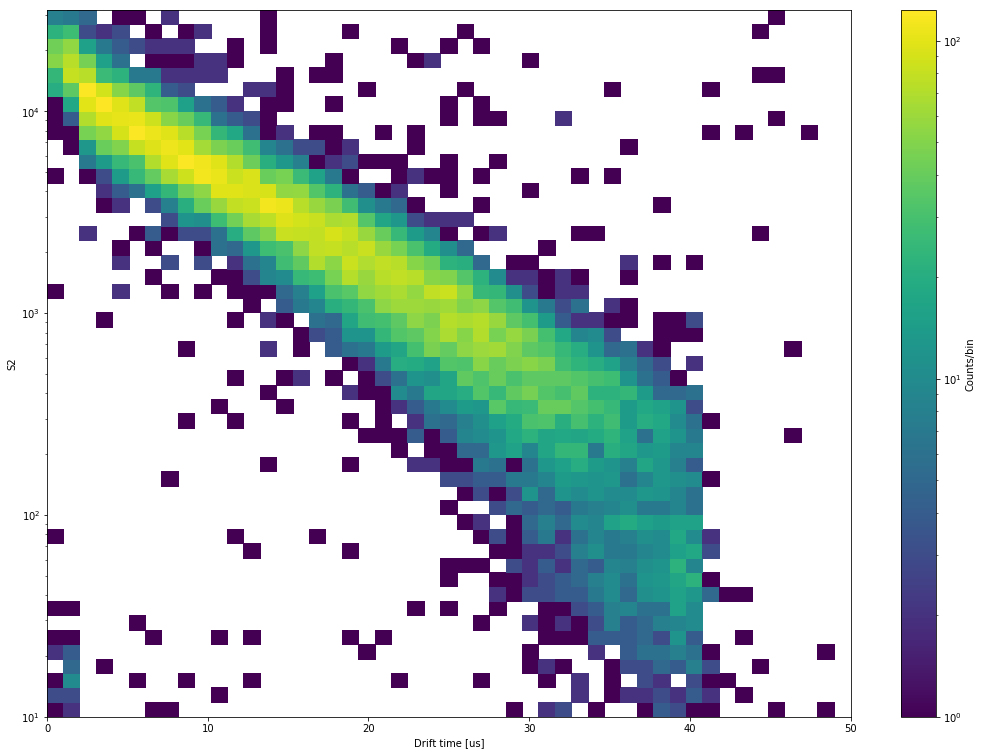

In [28]:
line = event_basics[(80<event_basics['s1_area']) & (event_basics['s1_area'] < 300)]
fig, ax = plt.subplots(figsize=(18,13))

bins_x = np.linspace(0,50,50)
bins_y = np.logspace(1,4.5,50)
counts, xedges, yedges = np.histogram2d(line['drift_time']/1e3, line['s2_area'], bins=(bins_x, bins_y))
print(line['drift_time']/1e3)
im = ax.pcolormesh(bins_x, bins_y, counts.T, norm=LogNorm())
plt.colorbar(im,ax=ax, label='Counts/bin')
ax.set_yscale('log')

ax.set_xlabel('Drift time [us]')
ax.set_ylabel('S2')
plt.show()

In [29]:
xcenter = ((xedges[:-1]+xedges[1:])/2)
ycenter = ((yedges[:-1]+yedges[1:])/2)
# print(xcenter)
# print(ycenter)

[10391.171314579455, 9285.86958292804, 8401.173621542192, 7369.3719135012, 6587.613301277807, 5965.408648040419, 5296.6105702950035, 4724.00285704672, 4313.756985695057, 3939.3218092610077, 3452.5634697042765, 3114.4255796161665, 2829.7494101843495, 2463.3715856833574, 2292.1178574453324, 2026.8704217729694, 1795.7568779184296, 1549.691218166722, 1406.770937725462, 1223.2334104761921, 1105.5882816918856, 1003.0536688656646, 866.5887838831428, 765.1371693794899, 669.3105641635005, 608.0592963865815, 517.2454852733786]
[78.90185396161841, 42.094052126294976, 43.48630691919527, 36.44549021189721, 26.273849189818787, 25.20776897347247, 46.623987428470144, 17.993266746389576, 18.17099631175262, 27.16364188926533, 23.0160136643701, 29.269288080290213, 17.035438043738093, 20.228141089889778, 23.634911231862006, 27.506553209713775, 23.051828593114607, 13.296896817294709, 18.319078283900502, 18.02653050983065, 22.290677925458105, 17.081219750158958, 16.304838682606096, 11.06589180872837, 17.453

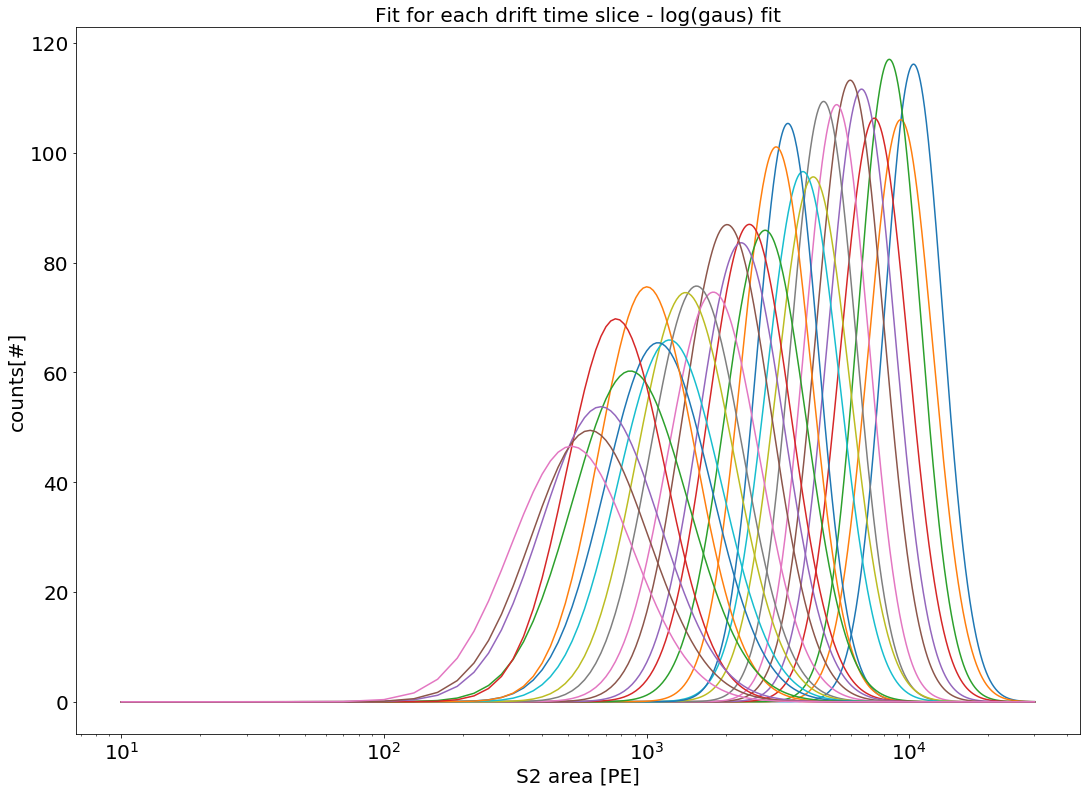

In [90]:
fig, ax = plt.subplots(figsize=(18,13))
#plt.scatter(ycenter, counts[30], c = 'r', marker = 'x')

fit_range= np.linspace(10,30000,1000)

def single_gaus(x, h, mu, sigma):

    gaus = h * np.exp(-(np.log(x)-mu)**2         /(2*sigma**2))
    return gaus
p0 = [60,8,8]
# bin_mask = bincenters[20:]
# n_mask = n[20:]
mu_list = []
mu_error_list = []
# popt, pcov = curve_fit(single_gaus, ycenter, counts[27], p0)
# plt.scatter(ycenter, counts[27], c = 'r', marker = 'x')
# plt.plot(fit_range, single_gaus(fit_range, *popt))
ax.set_xscale('log')
ax.set_title('Fit for each drift time slice - log(gaus) fit', fontsize = 20)
ax.set_xlabel('S2 area [PE]', fontsize = 20)
ax.set_ylabel('counts[#]', fontsize = 20)
for i in range(3,30):   
    popt, pcov = curve_fit(single_gaus, ycenter, counts[i], p0)
    #plt.scatter(ycenter, counts[i], c = 'r', marker = 'x')
    plt.plot(fit_range, single_gaus(fit_range, *popt))
    value = np.exp(popt[1])
    mu_list.append(value)
    perr = np.sqrt(np.diag(pcov))
    error_ln_mu = perr[1]
    error_mu = np.exp(popt[1])*error_ln_mu
    mu_error_list.append(error_mu)
    
print(mu_list)
print(mu_error_list)

# print(popt)
# print( np.exp(popt[1])) 
# print(np.exp(perr[1]))
# mu = (np.exp(popt[1]))
# perr = np.sqrt(np.diag(pcov))
# error_ln_mu = perr[1]
# error_mu = np.exp(popt[1])*error_ln_mu
# # print(popt)
# # print(perr)
# print('mu = ', mu, '+/- ', error_mu )
# plt.plot(bincenters,single_gaus(bincenters,*popt))                
# popt, pcov = curve_fit(single_gaus, bin_mask, n_mask, p0,  sigma=np.maximum(np.sqrt(n_mask), np.ones_like(n_mask)))
# plt.plot(bin_mask,single_gaus(bin_mask,*popt))
plt.show()




In [ ]:
print(counts[30])


this is lamba:  0.1071387707607015
this is 1/lamba:  9.333689316200369
[78.90185396161841, 42.094052126294976, 43.48630691919527, 36.44549021189721, 26.273849189818787, 25.20776897347247, 46.623987428470144, 17.993266746389576, 18.17099631175262, 27.16364188926533, 23.0160136643701, 29.269288080290213, 17.035438043738093, 20.228141089889778, 23.634911231862006, 27.506553209713775, 23.051828593114607, 13.296896817294709, 18.319078283900502, 18.02653050983065, 22.290677925458105, 17.081219750158958, 16.304838682606096, 11.06589180872837, 17.453704272573155, 15.240934335666715, 14.193024323417838]
electron lifetime:  9.333689316200369 +/- 0.02128211859136126


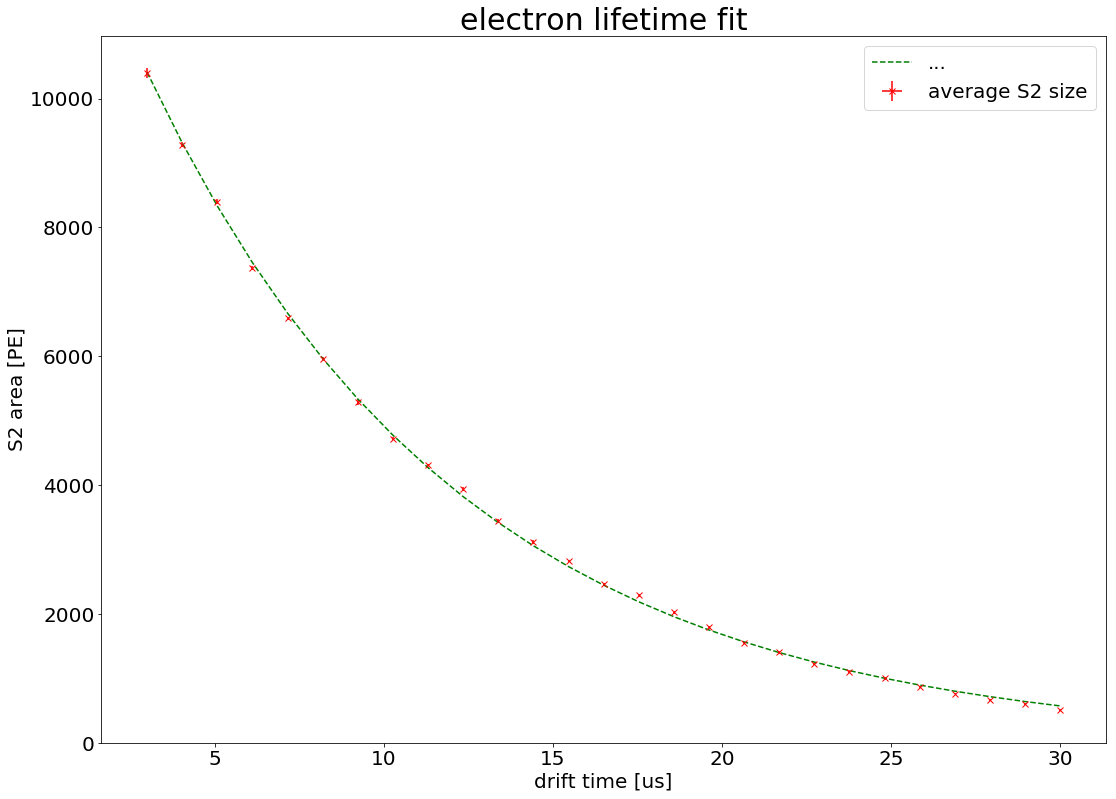

In [92]:
def expo(x, a, b):
    return a*np.exp(-b*x)

fig, ax =plt.subplots(figsize = (18,13))
p0=  [10000,0.1]
x = np.linspace(3,30,27)
y_values = mu_list
y_error = mu_error_list

SIZE = 20
EXTRA_SIZE = 30

plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=EXTRA_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)

popt, pcov = curve_fit(expo, x, y_values, sigma=y_error, p0=p0, absolute_sigma=True, maxfev= 10000)
plt.errorbar(x, y_values, yerr=y_error, xerr=0, fmt = 'rx', label = 'average S2 size' )

print('this is lamba: ', popt[1])
print('this is 1/lamba: ', 1/popt[1] )
plt.plot(x, expo(x, *popt), 'g--', label = '...')
print(y_error)

perr = np.sqrt(np.diag(pcov))
#ax.set_ylim([130,250])
ax.set_title('electron lifetime fit')
ax.set_xlabel('drift time [us]')
ax.set_ylabel('S2 area [PE]')

lifetime = 1/popt[1]
lifetime_error = (1/(popt[1]**2))*perr[1]
print('electron lifetime: ', lifetime, '+/-', lifetime_error)
# print(perr)
plt.legend(prop={'size': 20})
plt.show()

In [82]:
def expo(x, a, b):
    return a*np.exp(-b*x)
expo(3,100000,1)

4978.706836786395

In [ ]:
line = event_basics[(200<event_basics['s1_area']) & (event_basics['s1_area'] < 400)]
fig, ax = plt.subplots(figsize=(18,13))

bins_x = np.linspace(0,50,50)
bins_y = np.logspace(0.5,4,50)
counts, xedges, yedges = np.histogram2d(line['drift_time']/1e3, line['s2_area'], bins=(bins_x, bins_y))

im = ax.pcolormesh(bins_x, bins_y, counts.T, norm=LogNorm(), cmap = 'RdBu')
plt.colorbar(im,ax=ax, label='Counts/bin')

plt.scatter(xcenter[5:35], y_values, c = 'r', marker = 'x', s =110)

ax.set_yscale('log')

ax.set_xlabel('Drift time [us]')
ax.set_ylabel('S2')
plt.show()

In [ ]:
line = event_basics[(200<event_basics['s1_area']) & (event_basics['s1_area'] < 400)]
fig, ax = plt.subplots(figsize=(18,13))

bins_x = np.linspace(0,50,50)
#bins_y = np.logspace(1,3.5,50)
counts, binEdges = np.histogram(line['drift_time']/1e3, bins=bins_x)

#ax.set_yscale('log')
plt.hist(line['drift_time']/1e3, bins=bins_x, color='C5')
ax.set_xlabel('Drift time [us]')
ax.set_ylabel('S2')
plt.show()

In [94]:
eval('1'+'+2')

3

In [ ]:
run_list = ['00226', '00227']


for run in run_list:
    